# Evaluation

How often do regular differential expression analysis vs sophie prioritize the specific vs generic genes?

1. Simulate 1 template perturbation experiment using the technique above
2. Apply SOPHIE to get ranking of specific and generic genes based on their z-score.
3. Apply traditional DE analysis and get ranking of specific and generic genes based on their log fold change value
4. Compare the difference in ranking between specific and generic genes using SOPHIE vs traditional metrics.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
%matplotlib inline
import os
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri
from ponyo import utils, train_vae_modules, simulate_expression_data
from generic_expression_patterns_modules import (
    process,
    new_experiment_process,
    stats,
    ranking,
)

np.random.seed(1)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = "config_sophie_vs_trad.tsv"

params = utils.read_config(config_filename)

In [3]:
# Load config params

# Local directory to store intermediate files
local_dir = params["local_dir"]

#
dataset_name = params["dataset_name"]

# File containing un-normalized template experiment
raw_template_filename = params["raw_template_filename"]

# Un-normalized compendium filename
raw_compendium_filename = params["raw_compendium_filename"]

# Normalized compendium filename
normalized_compendium_filename = params["normalized_compendium_filename"]

# ID for template experiment to be selected
project_id = params["project_id"]

# Number of simulated experiments to generate
num_runs = params["num_simulated"]

# Directory containing trained VAE model
vae_model_dir = params["vae_model_dir"]

# Size of the latent dimension
latent_dim = params["latent_dim"]

# Scaler transform used to scale compendium data into 0-1 range for training
scaler_filename = params["scaler_filename"]

# Which DE method to use
# We recommend that if data is RNA-seq then use DESeq2
# If data is microarray then use Limma
de_method = params["DE_method"]

# If using DE-seq, setting this parameter will
# remove genes below a certain threshold
count_threshold = params["count_threshold"]

# Metadata file that specifies which samples to keep for DE analysis (Optional)
template_process_samples_filename = params["template_process_samples_filename"]

# Metadata file that specifies sample grouping for DE analysis
template_DE_grouping_filename = params["template_DE_grouping_filename"]

# Statistic to use to rank genes or pathways by
# Choices are {} FILL IN
col_to_rank_genes = params["rank_genes_by"]

# Pickle files saving specific and generic gene ids
template_specific_gene_ids_filename = params["template_specific_gene_ids_filename"]
generic_gene_ids_filename = "generic_gene_ids.pickle"

In [4]:
# Files generated by this notebook

# File storing template experiment with gene ids mapped to compendium gene ids
mapped_template_filename = params["mapped_template_filename"]

# File storing normalized template experiment
normalized_template_filename = params["normalized_template_filename"]

# File storing processed template experiment,
# after samples have been selected for comparison in DE analysis
processed_template_filename = params["processed_template_filename"]

# Output summary file
output_filename = params["output_filename"]

## SOPHIE

In [5]:
# Process template
new_experiment_process.process_template_experiment(
    raw_template_filename,
    raw_compendium_filename,
    scaler_filename,
    mapped_template_filename,
    normalized_template_filename,
)

(8, 1000)
(720, 1000)


In [6]:
# Simulate multiple experiments UPDATE COMMENT
# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:
#   - selected_simulated_data_SRP012656_<n>.txt
#   - selected_simulated_encoded_data_SRP012656_<n>.txt
#   - template_normalized_data_SRP012656_test.txt
# in which "<n>" is an integer in the range of [0, num_runs-1]

# REMOVE LATER
# dataset_name = "pre_model_unseen_template"
# Load pickled file
scaler = pickle.load(open(scaler_filename, "rb"))

# Update simulated dir
os.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)

# Update to take in file to be consisten
normalized_compendium = pd.read_csv(
    normalized_compendium_filename, header=0, sep="\t", index_col=0
)
normalized_template = pd.read_csv(
    normalized_template_filename, header=0, sep="\t", index_col=0
)
# ------------
# Update call when new version of ponyo
for run_id in range(num_runs):
    new_experiment_process.embed_shift_template_experiment(
        normalized_compendium,
        normalized_template,
        vae_model_dir,
        project_id,
        scaler_filename,
        local_dir,
        latent_dim,
        run_id,
    )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [7]:
## Update simulated dir
if not os.path.exists(template_process_samples_filename):
    template_process_samples_filename = None

if de_method == "deseq":
    # Process template data
    stats.process_samples_for_DESeq(
        raw_template_filename,
        template_DE_grouping_filename,
        processed_template_filename,
        count_threshold,
        template_process_samples_filename,
    )

    # Process simulated data
    for i in range(num_runs):
        simulated_filename = os.path.join(
            local_dir,
            "pseudo_experiment",
            f"selected_simulated_data_{project_id}_{i}.txt",
        )
        out_simulated_filename = os.path.join(
            local_dir,
            "pseudo_experiment",
            f"selected_simulated_data_{project_id}_{i}_processed.txt",
        )
        stats.process_samples_for_DESeq(
            simulated_filename,
            template_DE_grouping_filename,
            out_simulated_filename,
            count_threshold,
            template_process_samples_filename,
        )
else:
    stats.process_samples_for_limma(
        raw_template_filename,
        template_DE_grouping_filename,
        processed_template_filename,
        template_process_samples_filename,
    )

    for i in range(num_runs):
        simulated_filename = os.path.join(
            local_dir,
            "pseudo_experiment",
            f"selected_simulated_data_{project_id}_{i}.txt",
        )
        stats.process_samples_for_limma(
            simulated_filename,
            template_DE_grouping_filename,
            None,
            template_process_samples_filename,
        )

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


In [8]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [9]:
%%R -i template_DE_grouping_filename -i project_id -i processed_template_filename -i local_dir -i base_dir -i de_method

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
if (de_method == "deseq"){
    get_DE_stats_DESeq(
        template_DE_grouping_filename,
        project_id,
        processed_template_filename,
        "template",
        local_dir,
        "real"
    )
}
else{
    get_DE_stats_limma(
        template_DE_grouping_filename,
        project_id,
        processed_template_filename,
        "template",
        local_dir,
        "real"
    )
}

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply

[1] "Checking sample ordering..."
[1] TRUE


In [10]:
%%R -i template_DE_grouping_filename -i project_id -i base_dir -i local_dir -i num_runs -i de_method

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(
        local_dir,
        "pseudo_experiment/selected_simulated_data_",
        project_id,
        "_",
        i,
        "_processed.txt",
        sep = ""
    )
    if (de_method == "deseq"){
        get_DE_stats_DESeq(
            template_DE_grouping_filename,
            project_id,
            simulated_data_filename,
            "simulated",
            local_dir,
            i
            )
    }
    else {
        get_DE_stats_limma(
            template_DE_grouping_filename,
            project_id,
            simulated_data_filename,
            "simulated",
            local_dir,
            i
            )
        }
    }

[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "Checking sample ordering..."
[1] TRUE


R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



In [11]:
analysis_type = "DE"
template_DE_stats_filename = os.path.join(
    local_dir, "DE_stats", f"DE_stats_template_data_{project_id}_real.txt"
)

# Added
if de_method == "deseq":
    logFC_name = "log2FoldChange"
    pvalue_name = "padj"
else:
    logFC_name = "logFC"
    pvalue_name = "adj.P.Val"

template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
    logFC_name,
    pvalue_name,
)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [12]:
# Get summary table
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    "gene",
    params,
)

summary_gene_ranks.sort_values(by="Z score", ascending=False).head(10)

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
G_389,G_389,6.394142e-08,976.0,7.077979,7.077979,0.999405,863.0,86.286286,0.0,0.275134,0.094161,10,72.246812
G_791,G_791,6.249261e-01,917.0,2.360640,-2.360640,0.999405,94.0,9.309309,0.0,0.069259,0.039431,10,58.111384
G_113,G_113,6.394142e-08,974.5,7.065242,7.065242,0.999294,869.0,86.886887,0.0,0.295537,0.128841,10,52.543182
G_331,G_331,2.782124e-03,919.0,2.404359,2.404359,0.999405,311.0,31.031031,0.0,0.126083,0.053230,10,42.800661
G_348,G_348,5.978144e-04,962.0,4.767792,4.767792,0.999405,38.0,3.703704,0.0,0.113928,0.110045,10,42.290425
G_573,G_573,3.932986e-04,945.0,3.332977,3.332977,0.999405,445.0,44.444444,0.0,0.130349,0.076548,10,41.837958
G_596,G_596,1.996953e-01,883.0,1.813161,-1.813161,0.999405,113.0,11.211211,0.0,0.086199,0.047237,10,36.559705
G_817,G_817,6.394142e-08,977.0,7.078032,7.078032,0.998263,985.0,98.498498,0.0,0.445895,0.189126,10,35.067296
G_178,G_178,6.542156e-01,913.0,2.275653,2.275653,0.999405,474.0,47.347347,0.0,0.132313,0.061239,10,34.999861
G_594,G_594,4.422069e-01,938.0,2.900935,-2.900935,0.999405,155.0,15.415415,0.0,0.092686,0.083413,10,33.666683


In [13]:
summary_gene_ranks_sorted = summary_gene_ranks.sort_values(
    by="Z score", ascending=False
)

In [14]:
# Add ranking based on Z-score
summary_gene_ranks_sorted["rank"] = summary_gene_ranks_sorted["Z score"].rank(
    ascending=True
)

In [15]:
summary_gene_ranks_sorted.head(10)

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score,rank
G_389,G_389,6.394142e-08,976.0,7.077979,7.077979,0.999405,863.0,86.286286,0.0,0.275134,0.094161,10,72.246812,977.0
G_791,G_791,6.249261e-01,917.0,2.360640,-2.360640,0.999405,94.0,9.309309,0.0,0.069259,0.039431,10,58.111384,976.0
G_113,G_113,6.394142e-08,974.5,7.065242,7.065242,0.999294,869.0,86.886887,0.0,0.295537,0.128841,10,52.543182,975.0
G_331,G_331,2.782124e-03,919.0,2.404359,2.404359,0.999405,311.0,31.031031,0.0,0.126083,0.053230,10,42.800661,974.0
G_348,G_348,5.978144e-04,962.0,4.767792,4.767792,0.999405,38.0,3.703704,0.0,0.113928,0.110045,10,42.290425,973.0
G_573,G_573,3.932986e-04,945.0,3.332977,3.332977,0.999405,445.0,44.444444,0.0,0.130349,0.076548,10,41.837958,972.0
G_596,G_596,1.996953e-01,883.0,1.813161,-1.813161,0.999405,113.0,11.211211,0.0,0.086199,0.047237,10,36.559705,971.0
G_817,G_817,6.394142e-08,977.0,7.078032,7.078032,0.998263,985.0,98.498498,0.0,0.445895,0.189126,10,35.067296,970.0
G_178,G_178,6.542156e-01,913.0,2.275653,2.275653,0.999405,474.0,47.347347,0.0,0.132313,0.061239,10,34.999861,969.0
G_594,G_594,4.422069e-01,938.0,2.900935,-2.900935,0.999405,155.0,15.415415,0.0,0.092686,0.083413,10,33.666683,968.0


## Traditional DE

In [16]:
%%R -i template_DE_grouping_filename -i project_id -i processed_template_filename -i local_dir -i base_dir -i de_method

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
if (de_method == "deseq"){
    get_DE_stats_DESeq(
        template_DE_grouping_filename,
        project_id,
        processed_template_filename,
        "template",
        local_dir,
        "real"
    )
}
else{
    get_DE_stats_limma(
        template_DE_grouping_filename,
        project_id,
        processed_template_filename,
        "template",
        local_dir,
        "real"
    )
}

[1] "Checking sample ordering..."
[1] TRUE


In [17]:
# Load DE statistics file
trad_de_stats_filename = os.path.join(
    local_dir, "DE_stats", f"DE_stats_template_data_{project_id}_real.txt"
)

trad_de_stats = pd.read_csv(trad_de_stats_filename, sep="\t", index_col=0, header=0)

In [18]:
# Sort by log fold change
trad_de_stats_sorted = trad_de_stats.sort_values(by="log2FoldChange", ascending=False)

In [19]:
# Add ranking based on log2FoldChange
trad_de_stats_sorted["rank"] = trad_de_stats_sorted["log2FoldChange"].rank(
    ascending=True
)

In [20]:
trad_de_stats_sorted.head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,rank
G_817,12.478039,7.078032,1.117569,6.333419,2.397871e-10,6.394142e-08,977.0
G_389,12.477496,7.077979,1.117557,6.333441,2.397538e-10,6.394142e-08,976.0
G_941,12.367961,7.065242,1.117941,6.319868,2.617868e-10,6.394142e-08,974.5
G_113,12.367961,7.065242,1.117941,6.319868,2.617868e-10,6.394142e-08,974.5
G_513,13.050699,6.406945,1.114187,5.750332,8.906818e-09,1.691798e-06,973.0
G_61,12.824291,6.381962,1.114901,5.724240,1.038975e-08,1.691798e-06,972.0
G_183,12.835988,5.649349,1.109059,5.093820,3.509199e-07,9.523577e-06,971.0
G_563,12.724293,5.636548,1.112384,5.067089,4.039452e-07,1.011935e-05,970.0
G_653,12.733455,5.634244,1.109053,5.080229,3.769798e-07,9.954305e-06,969.0
G_280,12.621258,5.622664,1.109557,5.067485,4.031059e-07,1.011935e-05,968.0


## Check signal in simulation experiment

In [62]:
i = 9

In [63]:
simulated_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_data_{project_id}_{i}.txt",
)

In [64]:
simulated_data = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

In [65]:
print(simulated_data.shape)
simulated_data.head()

(8, 1000)


,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,...,G_990,G_991,G_992,G_993,G_994,G_995,G_996,G_997,G_998,G_999
0_control,16.594,33.621,6.665,19.000,205.427,35.513,10.123,19.050,66.627,59.556,...,34.758,42.615,36.812,72.438,10.494,19.621,10.928,219.025,10.365,21.018
1_control,27.363,57.798,7.621,23.743,264.879,37.653,9.415,21.221,69.634,78.689,...,35.723,36.488,49.251,56.738,13.865,20.864,12.283,207.698,14.954,18.636
2_control,23.752,49.751,8.204,17.432,190.329,22.996,7.971,18.392,63.433,39.771,...,31.817,30.400,31.382,43.507,9.705,17.372,8.200,327.719,11.815,15.454
3_control,25.357,63.012,9.338,24.360,182.237,26.302,8.982,21.472,69.083,88.765,...,32.731,30.533,42.853,61.844,12.298,22.207,9.937,297.426,14.583,18.239
4_perturb,16.879,28.941,6.274,11.634,269.703,38.618,6.455,15.360,81.265,25.950,...,29.707,25.958,31.922,53.141,9.536,13.469,9.155,146.229,12.170,18.300


In [66]:
# Get common genes
# Get specific genes

# Load pickled file
with open(template_specific_gene_ids_filename, "rb") as specific_fh:
    specific_gene_ids = pickle.load(specific_fh)

with open(generic_gene_ids_filename, "rb") as generic_fh:
    generic_gene_ids = pickle.load(generic_fh)

In [67]:
# Get NA genes
all_gene_ids = simulated_data.columns
all_gene_ids_tmp = all_gene_ids.difference(specific_gene_ids)
na_gene_ids = all_gene_ids_tmp.difference(generic_gene_ids)

In [68]:
# Simulated data subsets
simulated_specific_df = simulated_data[specific_gene_ids]
simulated_common_df = simulated_data[generic_gene_ids]
simulated_na_df = simulated_data[na_gene_ids]

In [69]:
print(simulated_specific_df.shape)
simulated_specific_df

(8, 10)


,G_402,G_832,G_553,G_852,G_995,G_760,G_404,G_698,G_825,G_266
0_control,91.510,23.338,17.355,9.291,19.621,527.871,45.168,55.645,13.655,11.749
1_control,84.119,23.046,23.552,10.964,20.864,636.458,49.985,57.417,11.934,11.378
2_control,51.979,19.947,18.818,8.715,17.372,430.869,43.718,56.797,11.100,9.777
3_control,54.885,19.110,21.760,10.353,22.207,558.371,41.985,60.260,13.160,9.644
4_perturb,73.362,23.572,14.337,9.602,13.469,389.537,34.819,51.299,10.858,9.616
5_perturb,41.202,11.509,12.320,4.332,2.846,211.533,30.518,33.939,11.677,5.656
6_perturb,51.079,21.547,16.861,6.453,11.652,266.791,37.276,56.126,9.679,10.050
7_perturb,41.925,20.765,17.822,7.907,12.320,335.410,37.207,62.361,11.765,9.104


In [70]:
print(simulated_common_df.shape)
simulated_common_df

(8, 100)


,G_941,G_119,G_876,G_512,G_194,G_800,G_228,G_142,G_798,G_401,...,G_42,G_676,G_190,G_267,G_642,G_395,G_432,G_219,G_386,G_265
0_control,77.675,56.012,77.389,11.598,16.507,16.538,40.331,108.673,19.888,39.290,...,9.299,28.769,58.827,62.824,53.811,59.194,17.118,25.779,77.992,67.382
1_control,78.236,34.392,79.930,15.024,22.813,18.634,42.993,120.200,23.047,39.046,...,13.075,29.657,88.188,74.390,93.128,65.652,19.076,27.592,81.764,142.164
2_control,67.003,45.028,91.846,12.537,17.860,15.256,32.145,108.873,27.223,36.216,...,8.898,21.237,67.309,65.215,69.376,59.689,21.769,34.652,76.650,99.691
3_control,67.650,36.285,77.864,13.107,17.260,18.228,33.167,121.280,41.263,37.462,...,9.975,29.071,104.383,68.547,90.953,59.884,23.311,44.077,67.329,216.295
4_perturb,111.510,39.114,96.284,14.104,15.613,15.120,35.844,141.007,18.021,32.112,...,9.273,20.370,52.883,60.398,37.243,70.072,17.634,15.673,104.873,50.102
5_perturb,81.192,21.241,97.396,14.369,11.798,5.826,12.752,117.305,11.999,40.933,...,4.726,14.347,22.350,60.108,41.346,72.197,26.753,15.940,114.221,60.031
6_perturb,81.925,38.444,104.367,11.613,14.849,11.440,25.580,124.422,18.796,32.019,...,9.790,16.451,46.221,75.485,53.061,65.955,23.140,20.235,115.222,44.677
7_perturb,74.614,57.221,99.750,10.429,13.367,14.100,25.277,126.971,30.415,42.742,...,6.896,22.314,51.226,61.513,58.457,62.059,23.275,27.485,93.391,79.607


In [71]:
print(simulated_na_df.shape)
simulated_na_df

(8, 890)


,G_0,G_1,G_10,G_100,G_101,G_102,G_103,G_104,G_105,G_106,...,G_99,G_990,G_991,G_992,G_993,G_994,G_996,G_997,G_998,G_999
0_control,16.594,33.621,64.006,23.813,2185.793,26.179,89.793,25.325,62.751,33.518,...,12.347,34.758,42.615,36.812,72.438,10.494,10.928,219.025,10.365,21.018
1_control,27.363,57.798,63.969,26.130,2693.438,19.378,93.805,30.699,70.864,29.378,...,16.202,35.723,36.488,49.251,56.738,13.865,12.283,207.698,14.954,18.636
2_control,23.752,49.751,58.703,18.694,1913.737,26.224,76.708,23.025,59.112,21.017,...,14.396,31.817,30.400,31.382,43.507,9.705,8.200,327.719,11.815,15.454
3_control,25.357,63.012,57.294,21.541,2380.946,24.447,72.380,25.930,63.974,22.692,...,15.788,32.731,30.533,42.853,61.844,12.298,9.937,297.426,14.583,18.239
4_perturb,16.879,28.941,83.648,17.408,1670.931,20.642,116.115,13.269,75.743,27.665,...,9.899,29.707,25.958,31.922,53.141,9.536,9.155,146.229,12.170,18.300
5_perturb,26.431,46.971,91.198,10.173,1979.029,15.510,111.561,9.856,81.155,19.391,...,9.005,24.671,13.059,15.438,29.027,4.869,2.987,106.660,10.083,7.597
6_perturb,22.998,37.814,72.149,14.968,1208.885,17.906,90.540,13.600,64.903,16.738,...,16.451,37.730,25.427,30.000,47.206,7.334,6.200,308.512,13.265,13.490
7_perturb,18.658,39.347,73.140,14.590,1774.599,28.628,83.060,13.863,62.313,21.183,...,14.237,30.032,29.785,26.689,47.232,8.366,6.974,267.776,10.112,19.470


Text(0.5, 0.98, 'Simulated experiment specific genes')

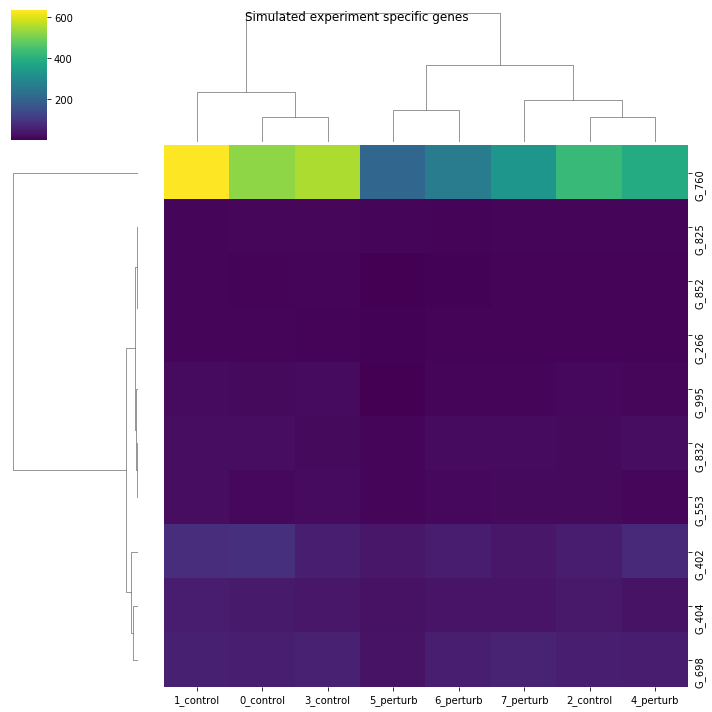

In [72]:
f = sns.clustermap(simulated_specific_df.T, cmap="viridis")
f.fig.suptitle("Simulated experiment specific genes")

Text(0.5, 0.98, 'Simulated experiment common genes')

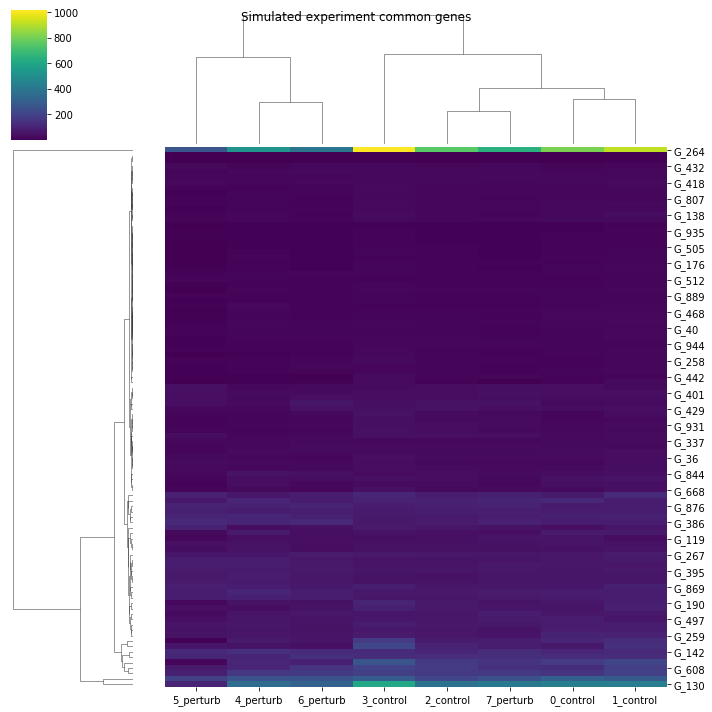

In [73]:
f = sns.clustermap(simulated_common_df.T, cmap="viridis")
f.fig.suptitle("Simulated experiment common genes")

Text(0.5, 0.98, 'Simulated experiment NA genes')

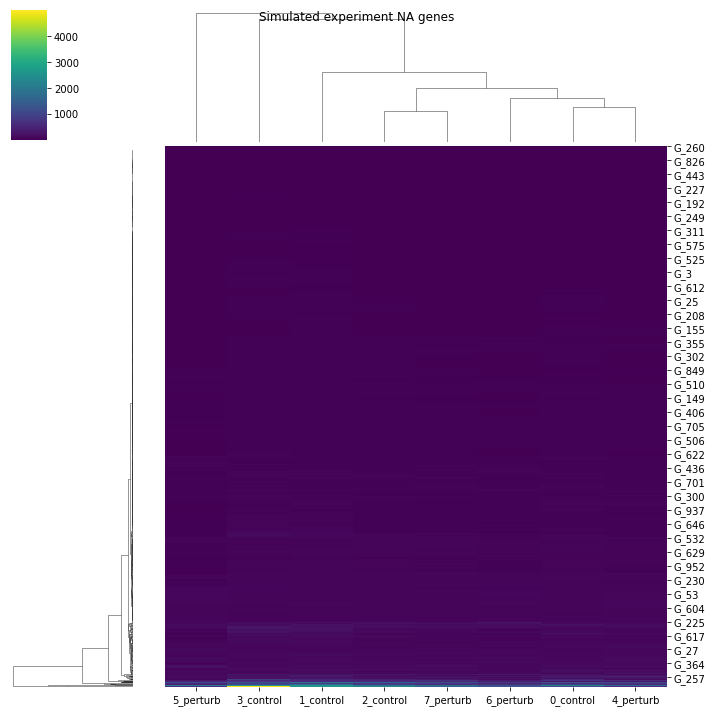

In [74]:
f = sns.clustermap(simulated_na_df.T, cmap="viridis")
f.fig.suptitle("Simulated experiment NA genes")

## Compare

Let's compare how the ranking of genes changes between SOPHIE and traditional methods. If SOPHIE was better able to distinguish between common vs specific genes then we would expect the ranking of specific genes to increase using SOPHIE and decrease for common genes.

### Clean up data for plotting

In [34]:
# Remove rows where the gene ranking is NaN due to the gene having a baseMean of 0
trad_na_rows = trad_de_stats_sorted[trad_de_stats_sorted["rank"].isna()].index
sophie_na_rows = summary_gene_ranks_sorted[
    summary_gene_ranks_sorted["rank"].isna()
].index

In [35]:
trad_de_stats_sorted_processed = trad_de_stats_sorted.drop(trad_na_rows)
summary_gene_ranks_sorted_processed = summary_gene_ranks_sorted.drop(sophie_na_rows)

In [36]:
print(trad_de_stats_sorted_processed.shape)
print(summary_gene_ranks_sorted_processed.shape)

(977, 7)
(977, 14)


In [37]:
# Get ranking
sophie_rank = summary_gene_ranks_sorted_processed["rank"].to_frame("sophie rank")
trad_rank = trad_de_stats_sorted_processed["rank"].to_frame("traditional rank")

In [38]:
# Load pickled file
with open(template_specific_gene_ids_filename, "rb") as specific_fh:
    specific_gene_ids = pickle.load(specific_fh)

with open(generic_gene_ids_filename, "rb") as generic_fh:
    generic_gene_ids = pickle.load(generic_fh)

In [39]:
# Add label for gene type
sophie_rank["gene type"] = "NA"
sophie_rank.loc[specific_gene_ids, "gene type"] = "specific"
sophie_rank.loc[generic_gene_ids, "gene type"] = "common"

In [40]:
print(sophie_rank.shape)
sophie_rank.head()

(977, 2)


,sophie rank,gene type
G_389,977.0,common
G_791,976.0,NA
G_113,975.0,common
G_331,974.0,specific
G_348,973.0,specific


In [41]:
print(trad_rank.shape)
trad_rank.head()

(977, 1)


,traditional rank
G_817,977.0
G_389,976.0
G_941,974.5
G_113,974.5
G_513,973.0


In [42]:
sophie_trad_rank = sophie_rank.merge(trad_rank, left_index=True, right_index=True)

In [43]:
sophie_trad_rank = sophie_trad_rank.reset_index()

In [44]:
print(sophie_trad_rank.shape)
sophie_trad_rank.head()

(977, 4)


,index,sophie rank,gene type,traditional rank
0,G_389,977.0,common,976.0
1,G_791,976.0,NA,9.0
2,G_113,975.0,common,974.5
3,G_331,974.0,specific,927.0
4,G_348,973.0,specific,962.0


In [45]:
sophie_trad_rank_melt = pd.melt(
    sophie_trad_rank,
    id_vars=["index", "gene type"],
    value_vars=["sophie rank", "traditional rank"],
)

In [46]:
print(sophie_trad_rank_melt.shape)
sophie_trad_rank_melt.head()

(1954, 4)


,index,gene type,variable,value
0,G_389,common,sophie rank,977.0
1,G_791,NA,sophie rank,976.0
2,G_113,common,sophie rank,975.0
3,G_331,specific,sophie rank,974.0
4,G_348,specific,sophie rank,973.0


In [47]:
sophie_trad_rank_melt[sophie_trad_rank_melt["gene type"] == "specific"]

,index,gene type,variable,value
3,G_331,specific,sophie rank,974.0
4,G_348,specific,sophie rank,973.0
5,G_573,specific,sophie rank,972.0
12,G_438,specific,sophie rank,965.0
30,G_435,specific,sophie rank,947.0
107,G_951,specific,sophie rank,870.0
347,G_377,specific,sophie rank,630.0
386,G_304,specific,sophie rank,591.0
642,G_107,specific,sophie rank,335.0
652,G_801,specific,sophie rank,325.0


Text(14.860859374999997, 0.5, 'Gene ranking')

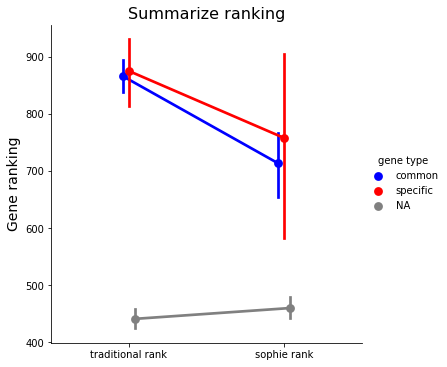

In [48]:
fig = sns.catplot(
    x="variable",
    y="value",
    data=sophie_trad_rank_melt,
    hue="gene type",
    join=True,
    palette=["blue", "red", "grey"],
    hue_order=["common", "specific", "NA"],
    order=["traditional rank", "sophie rank"],
    dodge=True,
    kind="point",
)
plt.title("Summarize ranking", fontsize=16)
plt.xlabel("")
plt.ylabel("Gene ranking", fontsize=14)

Text(-2.450000000000003, 0.5, 'Gene ranking')

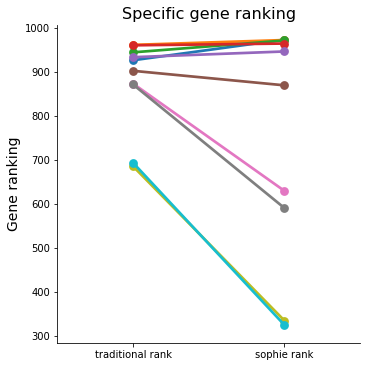

In [49]:
fig = sns.catplot(
    x="variable",
    y="value",
    data=sophie_trad_rank_melt[sophie_trad_rank_melt["gene type"] == "specific"],
    hue="index",
    join=True,
    # palette=["blue", "red", "grey"],
    # hue_order=["common", "specific", "NA"],
    order=["traditional rank", "sophie rank"],
    # dodge=True,
    kind="point",
    legend=False,
)
plt.title("Specific gene ranking", fontsize=16)
plt.xlabel("")
plt.ylabel("Gene ranking", fontsize=14)

Text(-2.450000000000003, 0.5, 'Gene ranking')

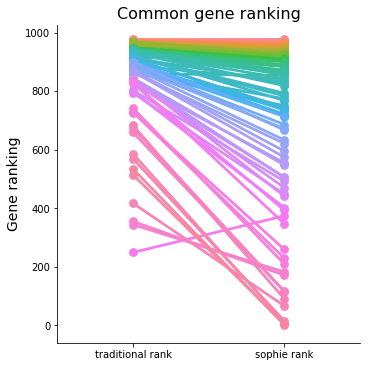

In [50]:
fig = sns.catplot(
    x="variable",
    y="value",
    data=sophie_trad_rank_melt[sophie_trad_rank_melt["gene type"] == "common"],
    hue="index",
    join=True,
    # palette=plot_color_gradients("sequential","blues"),
    # hue_order=["common", "specific", "NA"],
    order=["traditional rank", "sophie rank"],
    # dodge=True,
    kind="point",
    legend=False,
)
plt.title("Common gene ranking", fontsize=16)
plt.xlabel("")
plt.ylabel("Gene ranking", fontsize=14)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 27.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 50.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 49.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

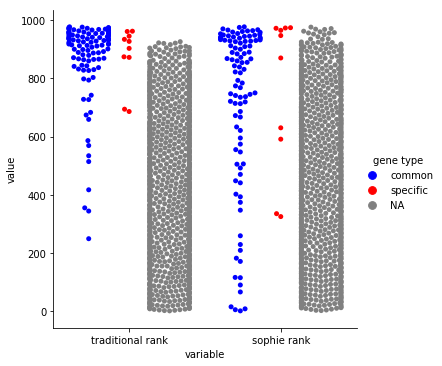

In [51]:
sns.catplot(
    x="variable",
    y="value",
    data=sophie_trad_rank_melt,
    hue="gene type",
    # join=True,
    palette=["blue", "red", "grey"],
    hue_order=["common", "specific", "NA"],
    order=["traditional rank", "sophie rank"],
    dodge=True,
    kind="swarm",
)

## Compare

1. mean rank of specific genes - mean rank of generic genes for template experiment
2. We will need to re-run this notebook for each template experiment and then plot the distribution of difference scores

We want to compare the mean ranking of specific genes vs the mean ranking of generic genes. If the mean difference is large then yes, that would indicate that there is a difference between the specific and generic genes that we can detect. In addition to the difference we want the specific genes to be higher ranked compared to the generic ones, so we want to see a large positive value if the method is performing better.

In [52]:
"""# Load pickled file
with open(template_specific_gene_ids_filename, "rb") as specific_fh:
    specific_gene_ids = pickle.load(specific_fh)

with open(generic_gene_ids_filename, "rb") as generic_fh:
    generic_gene_ids = pickle.load(generic_fh)"""

'# Load pickled file\nwith open(template_specific_gene_ids_filename, "rb") as specific_fh:\n    specific_gene_ids = pickle.load(specific_fh)\n\nwith open(generic_gene_ids_filename, "rb") as generic_fh:\n    generic_gene_ids = pickle.load(generic_fh)'

In [53]:
""" # Get mean of specific gene ranks
sophie_specific_mean = summary_gene_ranks_sorted.loc[specific_gene_ids, "rank"].mean()
trad_specific_mean = trad_de_stats_sorted.loc[specific_gene_ids, "rank"].mean()"""

' # Get mean of specific gene ranks\nsophie_specific_mean = summary_gene_ranks_sorted.loc[specific_gene_ids, "rank"].mean()\ntrad_specific_mean = trad_de_stats_sorted.loc[specific_gene_ids, "rank"].mean()'

In [54]:
"""print(sophie_specific_mean)
print(trad_specific_mean)"""

'print(sophie_specific_mean)\nprint(trad_specific_mean)'

In [55]:
# summary_gene_ranks_sorted.loc[specific_gene_ids, "rank"]

In [56]:
# trad_de_stats_sorted.loc[specific_gene_ids, "rank"]

In [57]:
# Get mean of generic gene ranks
# sophie_generic_mean = summary_gene_ranks_sorted.loc[generic_gene_ids, "rank"].mean()
# trad_generic_mean = trad_de_stats_sorted.loc[generic_gene_ids, "rank"].mean()

In [58]:
# print(sophie_generic_mean)
# print(trad_generic_mean)

In [59]:
# summary_gene_ranks_sorted.loc[generic_gene_ids, "rank"]

In [60]:
# trad_de_stats_sorted.loc[generic_gene_ids, "rank"]

In [61]:
"""# Difference
diff_sophie = sophie_specific_mean - sophie_generic_mean
diff_trad = trad_specific_mean - trad_generic_mean

print("sophie difference: ", diff_sophie)
print("traditional difference: ", diff_trad)"""

'# Difference\ndiff_sophie = sophie_specific_mean - sophie_generic_mean\ndiff_trad = trad_specific_mean - trad_generic_mean\n\nprint("sophie difference: ", diff_sophie)\nprint("traditional difference: ", diff_trad)'